In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import CubicSpline
import flygym.mujoco
import flygym.mujoco.preprogrammed
from tqdm import trange
from pathlib import Path

import itertools

output_path = Path("./outputs")
output_path.mkdir(exist_ok=True)

In [2]:
def calculate_ddt(theta, r, w, phi, nu, R, alpha):
    """Given the current state variables theta, r and network parameters
    w, phi, nu, R, alpha, calculate the time derivatives of theta and r."""
    intrinsic_term = 2 * np.pi * nu
    phase_diff = theta[np.newaxis, :] - theta[:, np.newaxis]
    coupling_term = (r * w * np.sin(phase_diff - phi)).sum(axis=1)
    dtheta_dt = intrinsic_term + coupling_term
    dr_dt = alpha * (R - r)
    return dtheta_dt, dr_dt

class CPGNetwork:
    def __init__(
        self,
        timestep,
        intrinsic_freqs,
        intrinsic_amps,
        coupling_weights,
        phase_biases,
        convergence_coefs,
        init_phases=None,
        init_magnitudes=None,
        seed=0,
    ) -> None:
        """Initialize a CPG network consisting of N oscillators.

        Parameters
        ----------
        timestep : float
            The timestep of the simulation.
        intrinsic_frequencies : np.ndarray
            The intrinsic frequencies of the oscillators, shape (N,).
        intrinsic_amplitudes : np.ndarray
            The intrinsic amplitude of the oscillators, shape (N,).
        coupling_weights : np.ndarray
            The coupling weights between the oscillators, shape (N, N).
        phase_biases : np.ndarray
            The phase biases between the oscillators, shape (N, N).
        convergence_coefs : np.ndarray
            Coefficients describing the rate of convergence to oscillator
            intrinsic amplitudes, shape (N,).
        init_phases : np.ndarray, optional
            Initial phases of the oscillators, shape (N,). The phases are
            randomly initialized if not provided.
        init_magnitudes : np.ndarray, optional
            Initial magnitudes of the oscillators, shape (N,). The
            magnitudes are randomly initialized if not provided.
        seed : int, optional
            The random seed to use for initializing the phases and
            magnitudes.
        """
        self.timestep = timestep
        self.num_cpgs = intrinsic_freqs.size
        self.intrinsic_freqs = intrinsic_freqs
        self.intrinsic_amps = intrinsic_amps
        self.coupling_weights = coupling_weights
        self.phase_biases = phase_biases
        self.convergence_coefs = convergence_coefs
        self.random_state = np.random.RandomState(seed)

        self.reset(init_phases, init_magnitudes)

        # Check if the parameters have the right shape
        assert intrinsic_freqs.shape == (self.num_cpgs,)
        assert coupling_weights.shape == (self.num_cpgs, self.num_cpgs)
        assert phase_biases.shape == (self.num_cpgs, self.num_cpgs)
        assert convergence_coefs.shape == (self.num_cpgs,)
        assert self.curr_phases.shape == (self.num_cpgs,)
        assert self.curr_magnitudes.shape == (self.num_cpgs,)

    def step(self):
        """Integrate the ODEs using Euler's method."""
        dtheta_dt, dr_dt = calculate_ddt(
            theta=self.curr_phases,
            r=self.curr_magnitudes,
            w=self.coupling_weights,
            phi=self.phase_biases,
            nu=self.intrinsic_freqs,
            R=self.intrinsic_amps,
            alpha=self.convergence_coefs,
        )
        self.curr_phases += dtheta_dt * self.timestep
        self.curr_magnitudes += dr_dt * self.timestep

    def reset(self, init_phases=None, init_magnitudes=None):
        """Reset the phases and magnitudes of the oscillators."""
        if init_phases is None:
            self.curr_phases = self.random_state.random(self.num_cpgs) * 2 * np.pi
        else:
            self.curr_phases = init_phases

        if init_magnitudes is None:
            self.curr_magnitudes = (
                self.random_state.random(self.num_cpgs) * self.intrinsic_amps
            )
        else:
            self.curr_magnitudes = init_magnitudes

In [3]:
base_path = Path("/Users/stimpfli/Desktop/nmf2-paper/revision_stepping/data/single_step_datasets/")
dofs_per_leg = [
        "Coxa",
        "Coxa_roll",
        "Coxa_yaw",
        "Femur",
        "Femur_roll",
        "Tibia",
        "Tarsus1",
    ]
legs = [f"{side}{pos}" for side in "LR" for pos in "FMH"]

def get_stepping_data(filename):
    with open(base_path / filename, "rb") as f:
        single_steps_data = pickle.load(f)
    
    preprogrammed_steps_length = len(single_steps_data["joint_LFCoxa"])
    preprogrammed_steps_timestep = single_steps_data["meta"]["timestep"]

    #Check that the data is consistent
    for k, v in single_steps_data.items():
        if k.startswith("joint_"):
            assert len(v) == preprogrammed_steps_length
            #assert v[0] == v[-1]

    # Interpolate the data
    phase_grid = np.linspace(0, 2 * np.pi, preprogrammed_steps_length)
    psi_funcs = {}
    for leg in legs:
        joint_angles = np.array(
            [single_steps_data[f"joint_{leg}{dof}"] for dof in dofs_per_leg]
        )
        
        psi_funcs[leg] = CubicSpline(phase_grid, joint_angles, axis=1, bc_type="periodic")

        theta_ts = np.linspace(0, 3 * 2 * np.pi, 10000)

    joint_angles_by_leg = {}
    for leg, psi_func in psi_funcs.items():
        joint_angles_by_leg[leg] = psi_func(theta_ts)

    swing_start = np.empty(6)
    swing_end = np.empty(6)
    for i, leg in enumerate(legs):
        swing_start[i] = single_steps_data["swing_stance_time"]["swing"][leg]
        swing_end[i] = single_steps_data["swing_stance_time"]["stance"][leg]
    swing_start /= preprogrammed_steps_length * preprogrammed_steps_timestep
    swing_start *= 2 * np.pi
    swing_end /= preprogrammed_steps_length * preprogrammed_steps_timestep
    swing_end *= 2 * np.pi

    # have the rest phase in between the swing and stance phase (as the data starts with swing initiation)
    psi_rest_phases = np.ones_like(swing_start)
    for i, leg in enumerate(legs):
        psi_rest_phases[i] = (swing_end[i] + 2*np.pi) / 2
    
    return psi_funcs, psi_rest_phases    

In [4]:
intrinsic_freqs = np.ones(6) * 12
intrinsic_amps = np.ones(6) * 1
phase_biases = np.pi * np.array(
    [
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
    ]
)
coupling_weights = (phase_biases > 0) * 10
convergence_coefs = np.ones(6) * 100


# Multiple seeds with different files and mirrored

In [37]:
run_time = 5
cam_name = "Animat/camera_left"
kp = 50.0
stifness = 10.0
damping = 10.0

mirrored = False

fly_trajs = []
exp_names = []

filenames = ["RF_0stance_RM_0stance_RH_0stance.pkl",
                 "RF_0stance_RM_0swing_LH_0stance.pkl",
                 "RF_0stance_RM_0swing_LH_1stance.pkl",
                 "RF_0stance_RM_0swing_LH_0swing.pkl",
                 "RF_1swing_RM_0stance_LH_0stance.pkl",
                 "RF_1swing_RM_0swing_LH_0stance.pkl",
                 "RF_1swing_RM_0swing_LH_1stance.pkl",
                 "RF_1swing_RM_0swing_LH_0swing.pkl",
                 ]

for filename in filenames:
    for mirrored in [True, False]:
        for seed in np.arange(5):
            psi_funcs, psi_rest_phases = get_stepping_data(filename)
            np.random.seed(seed)

            fly_traj = []

            sim_params = flygym.mujoco.Parameters(
                timestep=1e-4,
                render_mode="headless",
                render_playspeed=0.1,
                enable_adhesion=False,  # THIS HAS CHANGED
                render_camera=cam_name,
                tarsus_damping=damping,
                tarsus_stiffness=stifness
            )
            nmf = flygym.mujoco.NeuroMechFly(
                sim_params=sim_params,
                init_pose="stretch",
                actuated_joints=flygym.mujoco.preprogrammed.all_leg_dofs,
                control="position",
                xml="mjcf_ikpy_model"
            )

            cpg_network = CPGNetwork(
                timestep=1e-4,
                intrinsic_freqs=intrinsic_freqs,
                intrinsic_amps=intrinsic_amps,
                coupling_weights=coupling_weights,
                phase_biases=phase_biases,
                convergence_coefs=convergence_coefs,
                seed=seed)
            
            cpg_network.random_state = np.random.RandomState(seed)
            cpg_network.reset()
            obs, info = nmf.reset()

            for i in trange(int(run_time / sim_params.timestep)):
                cpg_network.step()
                joints_angles = {}
                for i, leg in enumerate(legs):
                    if mirrored:
                        cpg_phases = cpg_network.curr_phases[::-1]
                    else:
                        cpg_phases = cpg_network.curr_phases

                    psi = psi_funcs[leg](cpg_phases[i])
                    psi_base = psi_funcs[leg](psi_rest_phases[i])
                    adjusted_psi = psi_base + (psi - psi_base) * cpg_network.curr_magnitudes[i]
                    for dof, angle in zip(dofs_per_leg, adjusted_psi):
                        joints_angles[f"joint_{leg}{dof}"] = angle
                
                action = {
                    "joints": np.array([joints_angles[dof] for dof in nmf.actuated_joints]),
                }
                try:
                    obs, reward, terminated, truncated, info = nmf.step(action)
                except Exception as e:
                    print(e)
                    break
                #nmf.render()

                fly_traj.append(obs["fly"][0][:2])

        
            print(obs["fly"][0][0] - nmf.spawn_pos[0], obs["fly"][0][1] - nmf.spawn_pos[1])
            fly_trajs.append(fly_traj)
            exp_names.append(f"{seed}_mirrored{mirrored}_filename{filename}")

100%|██████████| 50000/50000 [00:38<00:00, 1292.62it/s]


68.9712905883789 -11.859723091125488


100%|██████████| 50000/50000 [00:45<00:00, 1093.07it/s]


68.66962432861328 -11.1850004196167


100%|██████████| 50000/50000 [00:40<00:00, 1238.77it/s]


68.00212097167969 -11.656042098999023


100%|██████████| 50000/50000 [00:43<00:00, 1139.18it/s]


67.93241882324219 -12.779780387878418


  0%|          | 0/50000 [00:00<?, ?it/s]


Physics state is invalid. Warning(s) raised: mjWARN_BADQACC
0.02880263328552246 -0.01067383959889412


100%|██████████| 50000/50000 [00:36<00:00, 1362.63it/s]


68.79365539550781 -10.216236114501953


100%|██████████| 50000/50000 [00:36<00:00, 1372.76it/s]


69.78140258789062 -8.843746185302734


100%|██████████| 50000/50000 [00:37<00:00, 1348.62it/s]


69.05138397216797 -11.802064895629883


100%|██████████| 50000/50000 [00:37<00:00, 1332.95it/s]


68.75714874267578 -8.130492210388184


100%|██████████| 50000/50000 [00:36<00:00, 1352.00it/s]


69.09581756591797 -11.389192581176758


100%|██████████| 50000/50000 [00:42<00:00, 1172.96it/s]


64.79702758789062 32.280540466308594


100%|██████████| 50000/50000 [00:41<00:00, 1192.99it/s]


61.13704299926758 41.33348083496094


100%|██████████| 50000/50000 [00:40<00:00, 1244.91it/s]


4.800206661224365 -0.46261924505233765


100%|██████████| 50000/50000 [00:40<00:00, 1226.56it/s]


0.5059285759925842 1.8836383819580078


  0%|          | 0/50000 [00:00<?, ?it/s]


Physics state is invalid. Warning(s) raised: mjWARN_BADQACC
0.02880263328552246 -0.01067383959889412


100%|██████████| 50000/50000 [00:41<00:00, 1214.17it/s]


0.999663233757019 -5.040278434753418


100%|██████████| 50000/50000 [00:40<00:00, 1225.43it/s]


2.8484413623809814 4.675272464752197


100%|██████████| 50000/50000 [00:40<00:00, 1232.70it/s]


-9.359315872192383 4.9762444496154785


100%|██████████| 50000/50000 [00:42<00:00, 1182.59it/s]


57.4576301574707 48.98927688598633


100%|██████████| 50000/50000 [00:43<00:00, 1143.23it/s]


76.68070220947266 -6.145340442657471


100%|██████████| 50000/50000 [00:43<00:00, 1137.80it/s]


52.351802825927734 46.392704010009766


100%|██████████| 50000/50000 [00:44<00:00, 1130.30it/s]


69.8377914428711 20.922119140625


100%|██████████| 50000/50000 [00:43<00:00, 1139.43it/s]


70.08964538574219 16.50487518310547


100%|██████████| 50000/50000 [00:45<00:00, 1108.66it/s]


22.363407135009766 54.4235725402832


  0%|          | 0/50000 [00:00<?, ?it/s]


Physics state is invalid. Warning(s) raised: mjWARN_BADQACC
0.02880263328552246 -0.01067383959889412


100%|██████████| 50000/50000 [00:45<00:00, 1103.06it/s]


23.319490432739258 59.62651062011719


100%|██████████| 50000/50000 [00:43<00:00, 1144.30it/s]


72.83032989501953 2.0529086589813232


100%|██████████| 50000/50000 [00:43<00:00, 1149.35it/s]


70.40184020996094 17.25756072998047


100%|██████████| 50000/50000 [00:44<00:00, 1120.59it/s]


49.995853424072266 51.99864959716797


100%|██████████| 50000/50000 [00:44<00:00, 1113.81it/s]


33.32018280029297 54.602474212646484


100%|██████████| 50000/50000 [00:40<00:00, 1223.01it/s]


-10.373968124389648 23.557737350463867


100%|██████████| 50000/50000 [00:40<00:00, 1226.63it/s]


-15.766121864318848 22.104963302612305


100%|██████████| 50000/50000 [00:41<00:00, 1210.41it/s]


-8.817724227905273 31.735260009765625


100%|██████████| 50000/50000 [00:41<00:00, 1217.71it/s]


29.3848876953125 40.18755340576172


  0%|          | 0/50000 [00:00<?, ?it/s]


Physics state is invalid. Warning(s) raised: mjWARN_BADQACC
0.02880263328552246 -0.01067383959889412


100%|██████████| 50000/50000 [00:41<00:00, 1208.05it/s]


-19.09156036376953 20.64763641357422


100%|██████████| 50000/50000 [00:48<00:00, 1020.91it/s]


24.804601669311523 29.571304321289062


100%|██████████| 50000/50000 [00:41<00:00, 1216.21it/s]


-4.927997589111328 28.741260528564453


100%|██████████| 50000/50000 [00:41<00:00, 1212.87it/s]


-11.79681396484375 33.14865493774414


100%|██████████| 50000/50000 [00:40<00:00, 1221.10it/s]


-11.31087589263916 23.12356185913086


100%|██████████| 50000/50000 [00:41<00:00, 1207.83it/s]


35.735408782958984 -12.726079940795898


100%|██████████| 50000/50000 [00:41<00:00, 1202.05it/s]


35.64338302612305 -11.286517143249512


100%|██████████| 50000/50000 [01:26<00:00, 579.85it/s] 


2.0329387187957764 5.977442264556885


  0%|          | 0/50000 [00:00<?, ?it/s]


Physics state is invalid. Warning(s) raised: mjWARN_BADQACC
0.02880263328552246 -0.01067383959889412


  0%|          | 0/50000 [00:00<?, ?it/s]


Physics state is invalid. Warning(s) raised: mjWARN_BADQACC
0.02880263328552246 -0.01067383959889412


100%|██████████| 50000/50000 [00:42<00:00, 1169.30it/s]


5.280689239501953 6.946378707885742


  0%|          | 0/50000 [00:00<?, ?it/s]


Physics state is invalid. Warning(s) raised: mjWARN_BADQACC
0.02880263328552246 -0.01067383959889412


100%|██████████| 50000/50000 [00:39<00:00, 1256.68it/s]


3.7537357807159424 7.6617608070373535


100%|██████████| 50000/50000 [00:40<00:00, 1242.40it/s]


2.459327459335327 9.464652061462402


100%|██████████| 50000/50000 [00:41<00:00, 1201.04it/s]


20.78193473815918 27.861831665039062


100%|██████████| 50000/50000 [00:42<00:00, 1185.14it/s]


28.43271255493164 -10.845114707946777


100%|██████████| 50000/50000 [00:42<00:00, 1182.88it/s]


26.262269973754883 -10.750054359436035


100%|██████████| 50000/50000 [00:39<00:00, 1253.55it/s]


-2.471811056137085 2.4728779792785645


  0%|          | 0/50000 [00:00<?, ?it/s]


Physics state is invalid. Warning(s) raised: mjWARN_BADQACC
0.02880263328552246 -0.01067383959889412


  0%|          | 0/50000 [00:00<?, ?it/s]


Physics state is invalid. Warning(s) raised: mjWARN_BADQACC
0.02880263328552246 -0.01067383959889412


100%|██████████| 50000/50000 [04:10<00:00, 199.29it/s] 


-0.6984837055206299 -0.8677812218666077


  0%|          | 0/50000 [00:00<?, ?it/s]


Physics state is invalid. Warning(s) raised: mjWARN_BADQACC
0.02880263328552246 -0.01067383959889412


100%|██████████| 50000/50000 [04:06<00:00, 202.90it/s] 


-2.6952478885650635 2.6759960651397705


100%|██████████| 50000/50000 [00:40<00:00, 1243.17it/s]


-2.44942045211792 5.584956645965576


100%|██████████| 50000/50000 [00:42<00:00, 1184.22it/s]


28.638628005981445 -10.609819412231445


100%|██████████| 50000/50000 [00:44<00:00, 1123.99it/s]


56.38833236694336 -11.677569389343262


100%|██████████| 50000/50000 [00:44<00:00, 1112.99it/s]


56.2777099609375 -21.018705368041992


100%|██████████| 50000/50000 [00:45<00:00, 1110.75it/s]


57.77450942993164 -19.444990158081055


  0%|          | 0/50000 [00:00<?, ?it/s]


Physics state is invalid. Warning(s) raised: mjWARN_BADQACC
0.02880263328552246 -0.01067383959889412


  0%|          | 0/50000 [00:00<?, ?it/s]


Physics state is invalid. Warning(s) raised: mjWARN_BADQACC
0.02880263328552246 -0.01067383959889412


100%|██████████| 50000/50000 [00:44<00:00, 1115.79it/s]


56.52363586425781 -5.732167720794678


  0%|          | 0/50000 [00:00<?, ?it/s]


Physics state is invalid. Warning(s) raised: mjWARN_BADQACC
0.02880263328552246 -0.01067383959889412


100%|██████████| 50000/50000 [00:45<00:00, 1105.27it/s]


57.2495002746582 -18.867780685424805


100%|██████████| 50000/50000 [00:46<00:00, 1078.15it/s]


22.484840393066406 54.568565368652344


100%|██████████| 50000/50000 [01:06<00:00, 751.01it/s] 


56.640438079833984 -20.876781463623047


100%|██████████| 50000/50000 [00:43<00:00, 1154.67it/s]


46.99230194091797 3.9737648963928223


100%|██████████| 50000/50000 [00:42<00:00, 1172.53it/s]


47.28055953979492 3.5816502571105957


100%|██████████| 50000/50000 [00:42<00:00, 1172.34it/s]


46.093994140625 2.5406417846679688


  0%|          | 0/50000 [00:00<?, ?it/s]


Physics state is invalid. Warning(s) raised: mjWARN_BADQACC
0.02880263328552246 -0.01067383959889412


  0%|          | 0/50000 [00:00<?, ?it/s]


Physics state is invalid. Warning(s) raised: mjWARN_BADQACC
0.02880263328552246 -0.01067383959889412


100%|██████████| 50000/50000 [00:42<00:00, 1163.71it/s]


46.50265884399414 5.034666061401367


  0%|          | 0/50000 [00:00<?, ?it/s]


Physics state is invalid. Warning(s) raised: mjWARN_BADQACC
0.02880263328552246 -0.01067383959889412


100%|██████████| 50000/50000 [00:43<00:00, 1147.10it/s]


47.70160675048828 4.501461029052734


100%|██████████| 50000/50000 [00:42<00:00, 1173.61it/s]


48.17280578613281 6.309701919555664


100%|██████████| 50000/50000 [1:11:05<00:00, 11.72it/s]   

46.61376953125 2.582073926925659


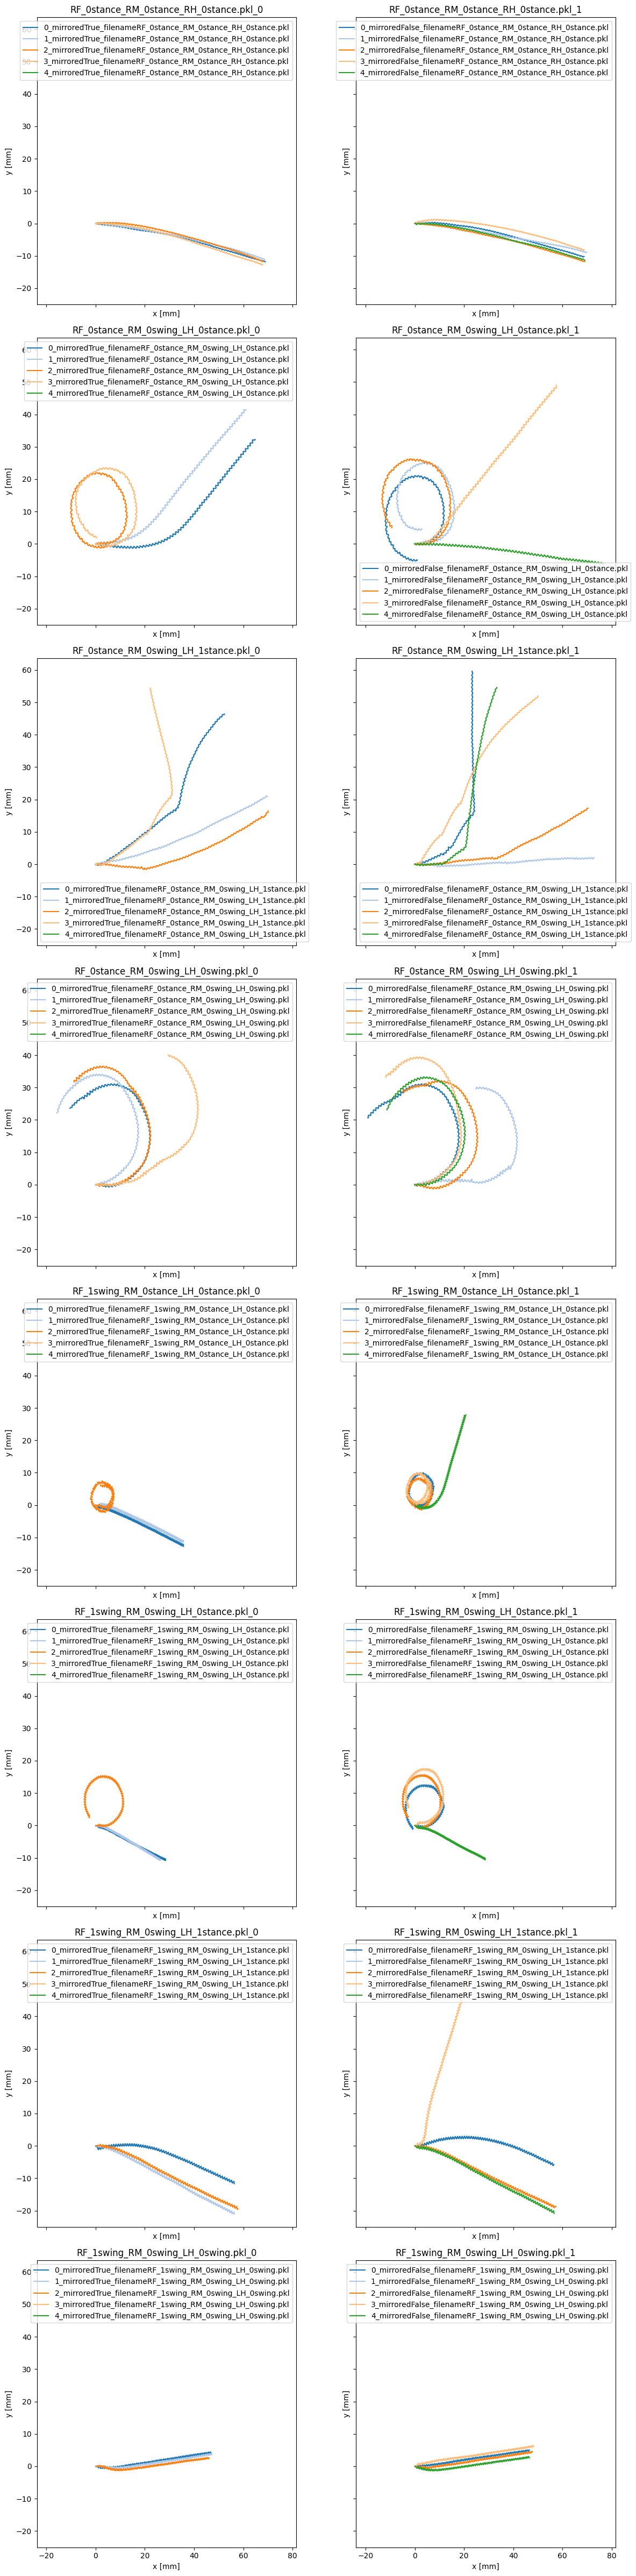

In [39]:
# plot two by two compared to the original data [None_mirroredFalse, None_mirroredTrue]
fig, axs = plt.subplots(len(filenames), 2, figsize=(12, 48), sharex=True, sharey=True)
colors = plt.cm.tab20.colors

color_map = {}
color_counter = np.zeros(np.shape(axs), dtype=int)
title_list = []

for i in range(len(exp_names)):
    traj = np.array(fly_trajs[i])
    param_val = exp_names[i].split("_")[0]

    exp_filename = "_".join(exp_names[i].split("_")[2:])[8:]
    plot_row = filenames.index(exp_filename)
    plot_col = 0 if "True" in exp_names[i] else 1
    
    title = exp_filename + "_" + str(plot_col)

    if title not in title_list:
        title_list.append(title)
    
    if param_val not in color_map:
        color_map[param_val] = color_counter[plot_row][plot_col]
        color_counter[plot_row][plot_col] += 1
    color_id = color_map[param_val]

    if len(traj) > 0:
        axs[plot_row][plot_col].plot(traj[:, 0], traj[:, 1], label=exp_names[i], color=colors[color_id])
    else:
        axs[plot_row][plot_col].plot(np.nan, np.nan, label=exp_names[i], color = colors[color_id])

axs = axs.flatten()
for title, ax in zip(title_list, axs):
    ax.legend()
    ax.set_xlabel("x [mm]")
    ax.set_ylabel("y [mm]")
    ax.set_title(title)

plt.tight_layout()
plt.show()

# Silence some dofs on top of that 

In [7]:
run_time = 5
cam_name = "Animat/camera_left"
kp = 50.0
stifness = 10.0
damping = 10.0

mirrored = False

fly_trajs = []
exp_names = []

filenames = ["RF_0stance_RM_0stance_RH_0stance.pkl",
                 "RF_0stance_RM_0swing_RH_0swing.pkl",
                 ]

filenames = ["RF_0stance_RM_0swing_RH_0swing.pkl"]

for dof_to_cancel in ["None"] + dofs_per_leg:
    for filename in filenames:
        for mirrored in [True, False]:
            for seed in [0]:
                psi_funcs, psi_rest_phases = get_stepping_data(filename)
                np.random.seed(seed)

                fly_traj = []

                sim_params = flygym.mujoco.Parameters(
                    timestep=1e-4,
                    render_mode="headless",
                    render_playspeed=0.1,
                    enable_adhesion=False,  # THIS HAS CHANGED
                    render_camera=cam_name,
                    tarsus_damping=damping,
                    tarsus_stiffness=stifness
                )
                nmf = flygym.mujoco.NeuroMechFly(
                    sim_params=sim_params,
                    init_pose="stretch",
                    actuated_joints=flygym.mujoco.preprogrammed.all_leg_dofs,
                    control="position",
                    xml="mjcf_ikpy_model"
                )

                cpg_network = CPGNetwork(
                    timestep=1e-4,
                    intrinsic_freqs=intrinsic_freqs,
                    intrinsic_amps=intrinsic_amps,
                    coupling_weights=coupling_weights,
                    phase_biases=phase_biases,
                    convergence_coefs=convergence_coefs,
                    seed=seed)
                
                cpg_network.random_state = np.random.RandomState(seed)
                cpg_network.reset()
                obs, info = nmf.reset()

                joints_to_keep = np.ones(len(dofs_per_leg), dtype=int)
                if dof_to_cancel != "None":
                    dof_to_cancel_index = dofs_per_leg.index(dof_to_cancel)
                    joints_to_keep[dof_to_cancel_index] = 0

                for i in trange(int(run_time / sim_params.timestep)):
                    cpg_network.step()
                    joints_angles = {}
                    for i, leg in enumerate(legs):
                        if mirrored:
                            cpg_phases = cpg_network.curr_phases[::-1]
                        else:
                            cpg_phases = cpg_network.curr_phases

                        psi = psi_funcs[leg](cpg_phases[i])
                        psi_base = psi_funcs[leg](psi_rest_phases[i])
                        adjusted_psi = psi_base + (psi - psi_base) * cpg_network.curr_magnitudes[i]*joints_to_keep
                        for dof, angle in zip(dofs_per_leg, adjusted_psi):
                            joints_angles[f"joint_{leg}{dof}"] = angle
                    
                    action = {
                        "joints": np.array([joints_angles[dof] for dof in nmf.actuated_joints]),
                    }
                    try:
                        obs, reward, terminated, truncated, info = nmf.step(action)
                    except Exception as e:
                        print(e)
                        break
                    #nmf.render()

                    fly_traj.append(obs["fly"][0][:2])

            
                print(obs["fly"][0][0] - nmf.spawn_pos[0], obs["fly"][0][1] - nmf.spawn_pos[1])
                fly_trajs.append(fly_traj)
                exp_names.append(f"{seed}_mirrored{mirrored}_filename{filename}_dof{dof_to_cancel}")

100%|██████████| 50000/50000 [00:41<00:00, 1191.79it/s]


35.13423538208008 44.71128845214844


100%|██████████| 50000/50000 [00:41<00:00, 1193.32it/s]


18.266677856445312 49.39694595336914


100%|██████████| 50000/50000 [00:49<00:00, 1000.20it/s]


18.747602462768555 18.821584701538086


100%|██████████| 50000/50000 [00:43<00:00, 1146.02it/s]


21.323762893676758 16.5222225189209


100%|██████████| 50000/50000 [00:44<00:00, 1124.54it/s]


11.224979400634766 24.537555694580078


100%|██████████| 50000/50000 [00:44<00:00, 1130.96it/s]


19.58700180053711 29.554462432861328


100%|██████████| 50000/50000 [00:39<00:00, 1256.12it/s]


53.67142105102539 40.485721588134766


100%|██████████| 50000/50000 [00:39<00:00, 1263.34it/s]


49.37163543701172 50.609432220458984


100%|██████████| 50000/50000 [00:33<00:00, 1501.73it/s]


-16.03046989440918 24.043670654296875


100%|██████████| 50000/50000 [00:34<00:00, 1459.95it/s]


3.1327593326568604 8.068148612976074


100%|██████████| 50000/50000 [01:36<00:00, 519.38it/s] 


21.56285285949707 -49.22283935546875


100%|██████████| 50000/50000 [1:08:20<00:00, 12.19it/s]  


24.169137954711914 -49.61698913574219


100%|██████████| 50000/50000 [01:09<00:00, 720.67it/s] 


35.71478271484375 -50.79966354370117


100%|██████████| 50000/50000 [00:57<00:00, 870.63it/s] 


63.1007080078125 3.663529396057129


100%|██████████| 50000/50000 [01:04<00:00, 772.54it/s] 


11.314607620239258 10.027447700500488


100%|██████████| 50000/50000 [00:57<00:00, 863.38it/s] 

9.666034698486328 10.096048355102539


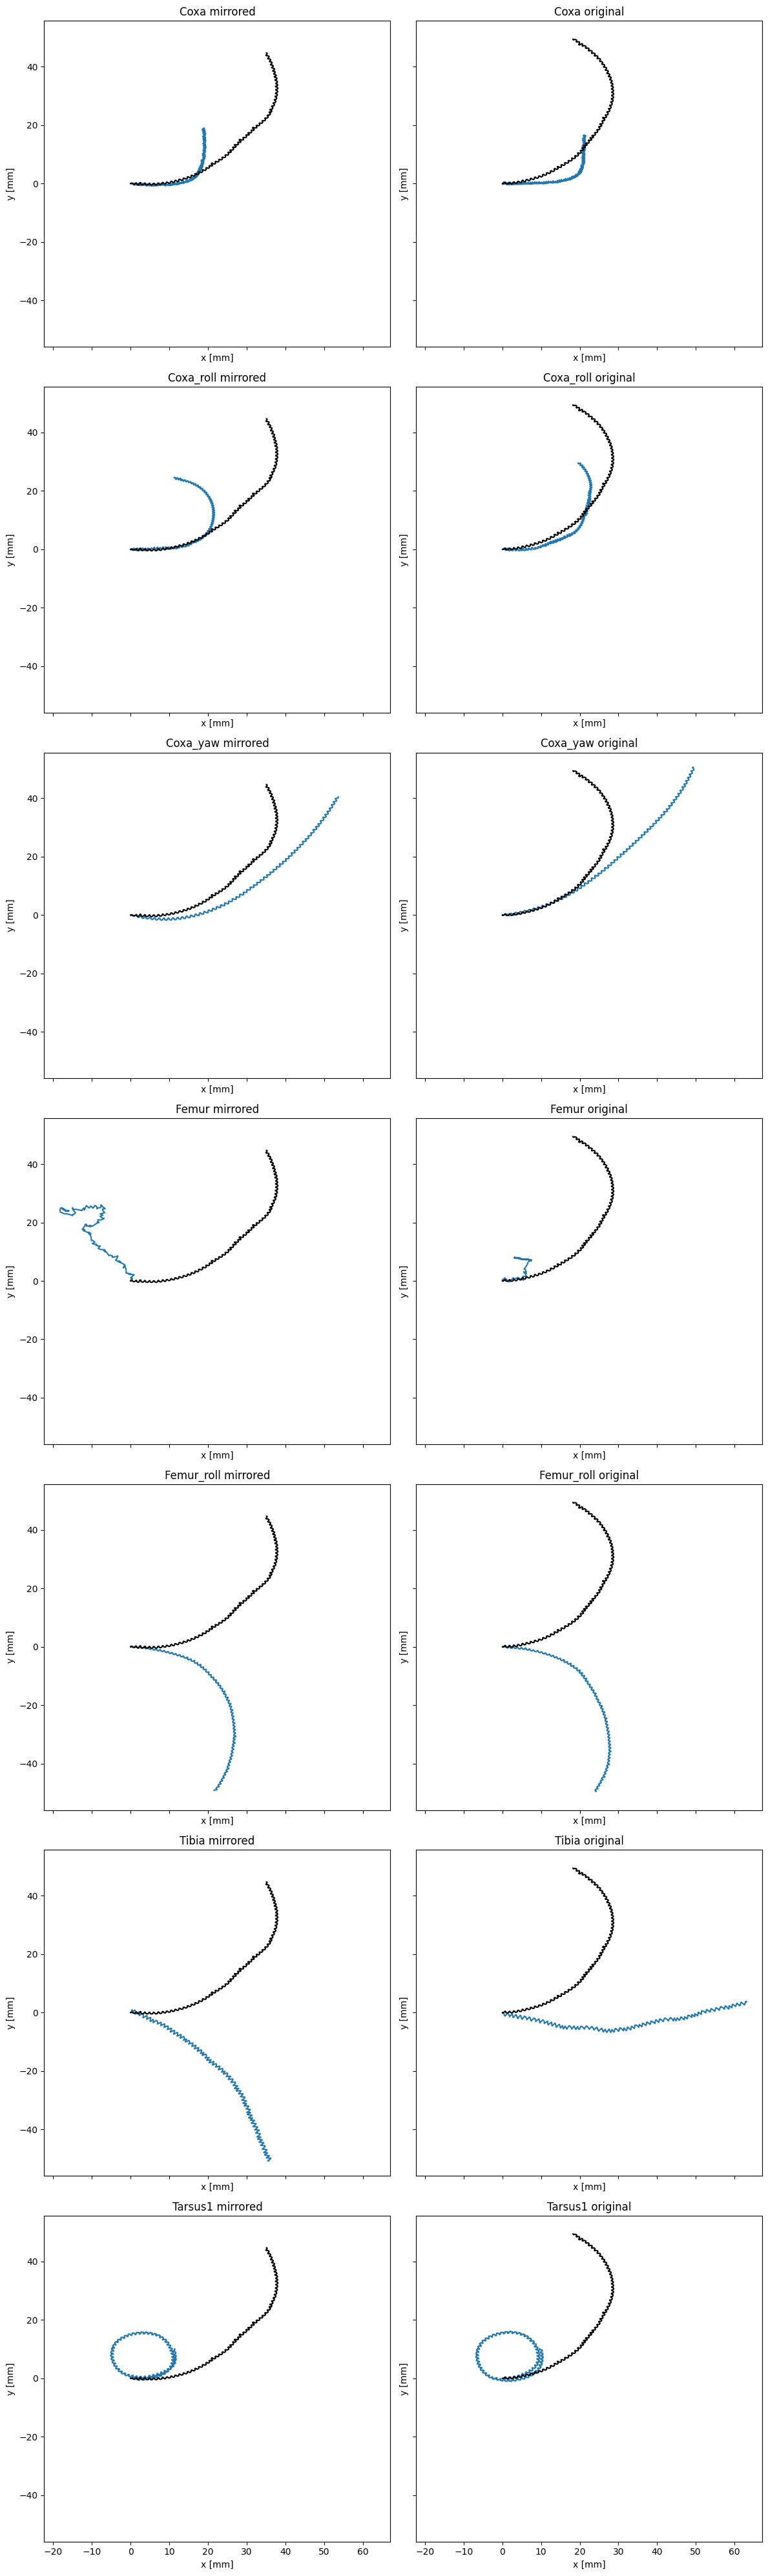

In [17]:
# plot two by two compared to the original data [None_mirroredFalse, None_mirroredTrue]
fig, axs = plt.subplots(len(dofs_per_leg), 2, figsize=(12, 40), sharex=True, sharey=True)
colors = plt.cm.tab20.colors

color_map = {}
color_counter = np.zeros(np.shape(axs), dtype=int)

title_list = []

for i in range(len(exp_names)):
    if "None" in exp_names[i]:
        continue

    traj = np.array(fly_trajs[i])
    param_val = "_".join(np.array(exp_names[i].split("_"))[[0, 2, 3, 4, 5, 6, 7]])

    dof = ""
    if "yaw" in exp_names[i] or "roll" in exp_names[i]:
        split_dof = exp_names[i].split("_")[-2:]
        dof_joint = split_dof[0][3:]
        dof = dof_joint + "_" + split_dof[1]

        ref_idx = exp_names.index("_".join(np.array(exp_names[i].split("_"))[:-2]) + "_dofNone")
    else:
        dof = exp_names[i].split("_")[-1][3:]
        ref_idx = exp_names.index("_".join(np.array(exp_names[i].split("_"))[:-1]) + "_dofNone")

    plot_row = dofs_per_leg.index(dof)
    plot_col = 0 if "True" in exp_names[i] else 1

    mirror_status = " mirrored" if "True" in exp_names[i] else " original"
    pot_title = dof + mirror_status
    if pot_title not in title_list:
        title_list.append(pot_title)
    
    if param_val not in color_map:
        color_map[param_val] = color_counter[plot_row][plot_col]
        color_counter[plot_row][plot_col] += 1
    color_id = color_map[param_val]

    if len(traj) > 0:
        axs[plot_row][plot_col].plot(traj[:, 0], traj[:, 1], label=exp_names[i], color=colors[color_id])
    else:
        axs[plot_row][plot_col].plot(np.nan, np.nan, label=exp_names[i], color = colors[color_id])

    traj_ref = np.array(fly_trajs[ref_idx])
    if len(traj_ref) > 0:
        axs[plot_row][plot_col].plot(traj_ref[:, 0], traj_ref[:, 1], label=exp_names[ref_idx], color="k")
    else:
        axs[plot_row][plot_col].plot(np.nan, np.nan, label=exp_names[ref_idx], color="k")

axs = axs.flatten()
for title, ax in zip(title_list, axs):
    #ax.legend()
    ax.set_xlabel("x [mm]")
    ax.set_ylabel("y [mm]")
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [18]:
run_time = 5
cam_name = "Animat/camera_left"
kp = 50.0
stifness = 10.0
damping = 10.0

mirrored = False

fly_trajs = []
exp_names = []

for mirrored in [True, False]:
    for seed in np.arange(10):
        psi_funcs, psi_rest_phases = get_stepping_data("RF_0stance_RM_0stance_RH_0stance.pkl")
        np.random.seed(seed)

        fly_traj = []

        sim_params = flygym.mujoco.Parameters(
            timestep=1e-4,
            render_mode="headless",
            render_playspeed=0.1,
            enable_adhesion=False,  # THIS HAS CHANGED
            render_camera=cam_name,
            tarsus_damping=damping,
            tarsus_stiffness=stifness
        )
        nmf = flygym.mujoco.NeuroMechFly(
            sim_params=sim_params,
            init_pose="stretch",
            actuated_joints=flygym.mujoco.preprogrammed.all_leg_dofs,
            control="position",
            xml="mjcf_ikpy_model"
        )

        cpg_network = CPGNetwork(
            timestep=1e-4,
            intrinsic_freqs=intrinsic_freqs,
            intrinsic_amps=intrinsic_amps,
            coupling_weights=coupling_weights,
            phase_biases=phase_biases,
            convergence_coefs=convergence_coefs,
            seed=seed)
        
        cpg_network.random_state = np.random.RandomState(seed)
        cpg_network.reset()
        obs, info = nmf.reset()

        for i in trange(int(run_time / sim_params.timestep)):
            cpg_network.step()
            joints_angles = {}
            for i, leg in enumerate(legs):
                if mirrored:
                    cpg_phases = cpg_network.curr_phases[::-1]
                else:
                    cpg_phases = cpg_network.curr_phases

                psi = psi_funcs[leg](cpg_phases[i])
                psi_base = psi_funcs[leg](psi_rest_phases[i])
                adjusted_psi = psi_base + (psi - psi_base) * cpg_network.curr_magnitudes[i]
                for dof, angle in zip(dofs_per_leg, adjusted_psi):
                    joints_angles[f"joint_{leg}{dof}"] = angle
            
            action = {
                "joints": np.array([joints_angles[dof] for dof in nmf.actuated_joints]),
            }
            try:
                obs, reward, terminated, truncated, info = nmf.step(action)
            except Exception as e:
                print(e)
                break
            #nmf.render()

            fly_traj.append(obs["fly"][0][:2])

    
        print(obs["fly"][0][0] - nmf.spawn_pos[0], obs["fly"][0][1] - nmf.spawn_pos[1])
        fly_trajs.append(fly_traj)
        exp_names.append(f"{seed}_mirrored{mirrored}")

100%|██████████| 50000/50000 [00:44<00:00, 1132.85it/s]


68.9712905883789 -11.859723091125488


100%|██████████| 50000/50000 [00:42<00:00, 1178.92it/s]


68.66962432861328 -11.1850004196167


100%|██████████| 50000/50000 [00:46<00:00, 1071.26it/s]


68.00212097167969 -11.656042098999023


100%|██████████| 50000/50000 [00:39<00:00, 1252.10it/s]


67.93241882324219 -12.779780387878418


  0%|          | 0/50000 [00:00<?, ?it/s]


Physics state is invalid. Warning(s) raised: mjWARN_BADQACC
0.02880263328552246 -0.01067383959889412


100%|██████████| 50000/50000 [00:40<00:00, 1243.79it/s]


68.30939483642578 -12.307013511657715


100%|██████████| 50000/50000 [00:39<00:00, 1276.13it/s]


69.3719711303711 -9.451444625854492


100%|██████████| 50000/50000 [00:40<00:00, 1236.55it/s]


68.58187103271484 -10.906997680664062


100%|██████████| 50000/50000 [00:38<00:00, 1291.80it/s]


28.090961456298828 -53.79179763793945


100%|██████████| 50000/50000 [00:38<00:00, 1313.89it/s]


68.60738372802734 -10.066625595092773


100%|██████████| 50000/50000 [00:38<00:00, 1295.38it/s]


68.79365539550781 -10.216236114501953


100%|██████████| 50000/50000 [00:37<00:00, 1345.78it/s]


69.78140258789062 -8.843746185302734


100%|██████████| 50000/50000 [00:38<00:00, 1313.21it/s]


69.05138397216797 -11.802064895629883


100%|██████████| 50000/50000 [00:42<00:00, 1186.83it/s]


68.75714874267578 -8.130492210388184


100%|██████████| 50000/50000 [00:42<00:00, 1173.35it/s]


69.09581756591797 -11.389192581176758


  0%|          | 0/50000 [00:00<?, ?it/s]


Physics state is invalid. Warning(s) raised: mjWARN_BADQACC
0.02880263328552246 -0.01067383959889412


100%|██████████| 50000/50000 [00:40<00:00, 1228.99it/s]


68.99242401123047 -9.39719009399414


100%|██████████| 50000/50000 [00:37<00:00, 1326.31it/s]


67.14871978759766 -16.599803924560547


100%|██████████| 50000/50000 [00:37<00:00, 1320.70it/s]


67.56725311279297 -9.41485595703125


100%|██████████| 50000/50000 [00:38<00:00, 1315.53it/s]

68.70535278320312 -11.237807273864746


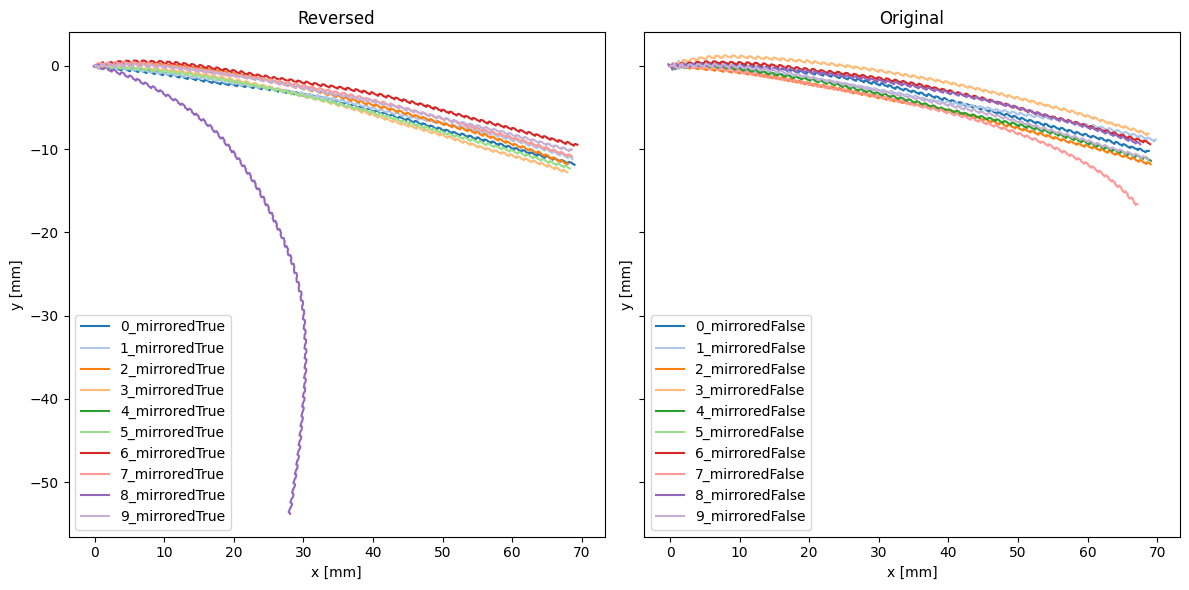

In [20]:
# plot two by two compared to the original data [None_mirroredFalse, None_mirroredTrue]
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
colors = plt.cm.tab20.colors

color_map = {}
color_counter = np.zeros(2, dtype=int)

title_list = []

for i in range(len(exp_names)):
    traj = np.array(fly_trajs[i])
    param_val = exp_names[i].split("_")[0]

    plot_col = 0 if "True" in exp_names[i] else 1

    pot_title = "Reversed" if plot_col == 0 else "Original"
    if pot_title not in title_list:
        title_list.append(pot_title)
    
    if param_val not in color_map:
        color_map[param_val] = color_counter[plot_col]
        color_counter[plot_col] += 1
    color_id = color_map[param_val]

    if len(traj) > 0:
        axs[plot_col].plot(traj[:, 0], traj[:, 1], label=exp_names[i], color=colors[color_id])
    else:
        axs[plot_col].plot(np.nan, np.nan, label=exp_names[i], color = colors[color_id])

axs = axs.flatten()
for title, ax in zip(title_list, axs):
    ax.legend()
    ax.set_xlabel("x [mm]")
    ax.set_ylabel("y [mm]")
    ax.set_title(title)

plt.tight_layout()
plt.show()